<a href="https://colab.research.google.com/github/qhung23125005/AIO/blob/main/AIO24/Module6/Transformer/VisionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import necessary libs

In [1]:
import torch
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import math
import os

#Data

##Download

In [2]:
!gdown 1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc

Downloading...
From (original): https://drive.google.com/uc?id=1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc
From (redirected): https://drive.google.com/uc?id=1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc&confirm=t&uuid=5fea28ea-44ac-4dea-af70-4705b4cb1b42
To: /content/flower_photos.zip
100% 230M/230M [00:02<00:00, 90.0MB/s]


In [4]:
!unzip flower_photos.zip

Archive:  flower_photos.zip
   creating: flower_photos/
   creating: flower_photos/daisy/
  inflating: flower_photos/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flower_photos/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flower_photos/daisy/10172379554_b296050f82_n.jpg  
  inflating: flower_photos/daisy/10172567486_2748826a8b.jpg  
  inflating: flower_photos/daisy/10172636503_21bededa75_n.jpg  
  inflating: flower_photos/daisy/102841525_bd6628ae3c.jpg  
  inflating: flower_photos/daisy/1031799732_e7f4008c03.jpg  
  inflating: flower_photos/daisy/10391248763_1d16681106_n.jpg  
  inflating: flower_photos/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flower_photos/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flower_photos/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flower_photos/daisy/10466290366_cc72e33532.jpg  
  inflating: flower_photos/daisy/10466558316_a7198b87e2.jpg  
  inflating: flower_photos/daisy/10555749515_13a12a026e.jpg  
  inflating: flower_photos/daisy/10

##Load data

In [6]:
data_path = './flower_photos'
dataset = ImageFolder(root = data_path)
num_samples = len(dataset)
classes = dataset.classes
num_classes = len(classes)

In [7]:
print(f'Number of samples: {num_samples}')
print(f'Number of classes: {num_classes}')

Number of samples: 3670
Number of classes: 5


##Split data

In [8]:
TRAIN_RATIO, VALID_RATIO = 0.8, 0.1

n_train_samples = int(num_samples * TRAIN_RATIO)
n_valid_samples = int(num_samples * VALID_RATIO)
n_test_samples = num_samples - n_train_samples - n_valid_samples

train_dataset, valid_dataset, test_dataset = random_split(
    dataset, [n_train_samples, n_valid_samples, n_test_samples]
)

##Preprocessing

In [9]:
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5 , 0.5 , 0.5] , [0.5 , 0.5 , 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5 , 0.5 , 0.5] , [0.5 , 0.5 , 0.5])
])

train_dataset.dataset.transform = train_transform
valid_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

##Create DataLoader

In [10]:
BATCH_SIZE = 512

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
)

#Training from scratch

##Modeling

###Encoder Block

In [18]:
class TransformerEncoder(nn.Module):
  def __init__(self, embed_dim, num_heads, ff_dim, dropout = 0.1):
    super(TransformerEncoder, self).__init__()
    self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first = True)
    self.ffn = nn.Sequential(
        nn.Linear(embed_dim, ff_dim, bias = True),
        nn.ReLU(),
        nn.Linear(ff_dim, embed_dim, bias = True),
    )
    self.norm1 = nn.LayerNorm(embed_dim, eps = 1e-6)
    self.norm2 = nn.LayerNorm(embed_dim, eps = 1e-6)
    self.dropout1 = nn.Dropout(dropout)
    self.dropout2 = nn.Dropout(dropout)

  def forward(self, query, key, value):
    attn_output, _ = self.attn(query, key, value)
    attn_output = self.dropout1(attn_output)
    out_1 = self.norm1(query + attn_output)
    ffn_output = self.ffn(out_1)
    ffn_output = self.dropout2(ffn_output)
    out_2 = self.norm2(out_1 + ffn_output)
    return out_2

##Patch Position Embedding

In [12]:
class PatchPositionEmbedding(nn.Module):
  def __init__(self, image_size =224, embed_dim =512, patch_size =16, device ='cpu'):
    super(PatchPositionEmbedding, self).__init__()
    self.conv1 = nn.Conv2d(
        3, embed_dim,
        kernel_size = patch_size,
        stride = patch_size,
        bias = False
    )
    scale = embed_dim**-0.5
    self.position_embed = nn.Parameter(
        scale*torch.randn((image_size//patch_size)**2, embed_dim)
    )
    self.device = device

  def forward(self, x):
    x = self.conv1(x) # shape = [* , width, grid , grid]
    x = x.reshape(x.shape[0], x.shape[1], -1) # shape = [*, width, grid ** 2]
    x = x.permute(0, 2, 1) #shape = [* , grid ** 2, width]
    x = x + self.position_embed.to(self.device)
    return x

###Main model

In [13]:
class VisionTransformer(nn.Module):
  def __init__(self,
               img_size,
               embed_dim,
               num_heads,
               ff_dim,
               dropout = 0.1,
               device = 'cpu',
               num_classes = 10,
               patch_size = 16):
    super(VisionTransformer, self).__init__()
    self.patch_embed = PatchPositionEmbedding(
        image_size = img_size,
        embed_dim = embed_dim,
        patch_size = patch_size,
        device = device
    )
    self.transformer = TransformerEncoder(
        embed_dim = embed_dim,
        num_heads = num_heads,
        ff_dim = ff_dim,
        dropout = dropout
    )
    self.fc1 = nn.Linear(embed_dim, num_classes)
    self.fc2 = nn.Linear(num_classes, num_classes)
    self.dropout = nn.Dropout(dropout)
    self.relu = nn.ReLU()

  def forward(self, x):
    output = self.patch_embed(x)
    output = self.transformer(output, output, output)
    output = output[:, 0, :]
    output = self.dropout(output)
    output = self.fc1(output)
    output = self.dropout(output)
    output = self.fc2(output)
    return output

##Train functions

###Epoch

In [14]:
def train_epoch(
    model, optimizer, criterion,
    train_dataloader, device, epoch = 0, log_interval = 50):

  model.train()
  total_acc, total_count = 0, 0
  losses = []

  for idx, (inputs, labels) in enumerate(train_dataloader):
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    predictions = model(inputs)
    #compute loss
    loss = criterion(predictions, labels)
    losses.append(loss.item())

    #backward
    loss.backward()
    optimizer.step()

    total_acc += (predictions.argmax(1) == labels).sum().item()
    total_count += labels.size(0)

    if idx % log_interval == 0 and idx > 0:
      print(
          "| epoch {:3d} | {:5d}/{:5d} batches "
          "| accuracy {:8.3f}".format(
              epoch, idx, len(train_dataloader),
              total_acc/total_count)
      )
      total_acc, total_count = 0, 0

  epoch_loss = sum(losses) / len(losses)
  epoch_acc = total_acc / total_count

  return epoch_acc, epoch_loss

In [15]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
  model.eval()
  total_acc, total_count = 0, 0
  losses = []

  with torch.no_grad():
    for idx, (inputs, labels) in enumerate(valid_dataloader):
      inputs, labels = inputs.to(device), labels.to(device)

      predictions = model(inputs)
      loss = criterion(predictions, labels)
      losses.append(loss.item())

      total_acc += (predictions.argmax(1) == labels).sum().item()
      total_count += labels.size(0)

  epoch_loss = sum(losses) / len(losses)
  epoch_acc = total_acc / total_count

  return epoch_acc, epoch_loss

###Main train function

In [16]:
def train(model, model_name, save_model,
          optimizer, criterion,
          train_dataloader, valid_dataloader,
          num_epochs, device):
  train_accs, train_losses = [], []
  valid_accs, valid_losses = [], []
  best_loss_eval = 100

  for epoch in range(1, num_epochs + 1):
    #Training
    train_acc, train_loss = train_epoch(
        model, optimizer, criterion,
        train_dataloader, device, epoch
    )
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    #Evaluation
    valid_acc, valid_loss = evaluate_epoch(
        model, criterion, valid_dataloader, device
    )
    valid_accs.append(valid_acc)
    valid_losses.append(valid_loss)

    #Save best model
    if valid_loss < best_loss_eval:
      best_loss_eval = valid_loss
      torch.save(model.state_dict(), save_model +  f'/{model_name}.pt')

    #Print
    print('-'*100)
    print(
        '| end of epoch {:3d} | train loss {:5.2f} | '
        'train acc {:8.3f} | valid loss {:5.2f} | '
        'valid acc {:8.3f}'.format(
            epoch, train_loss, train_acc, valid_loss, valid_acc
        )
    )
    print('-'*100)

  #Load best model
  model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
  model.eval()
  metrics = {
      'train_accuracy': train_accs,
      'train_loss': train_losses,
      'valid_accuracy': valid_accs,
      'valid_loss': valid_losses
  }

  return model, metrics

##Training

In [19]:
img_size = 224
embed_dim = 512
num_heads = 4
ff_dim = 128
dropout =0.1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = VisionTransformer(
    img_size=img_size,
    embed_dim=embed_dim,
    num_heads=num_heads,
    ff_dim=ff_dim,
    dropout=dropout,
    device=device,
    num_classes=num_classes
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 100
save_model = './ vit_flowers'
os.makedirs(save_model, exist_ok=True)
model_name = 'vit_flowers'

model, metrics = train(
    model, model_name, save_model,
    optimizer, criterion,
    train_loader, valid_loader,
    num_epochs, device
)

----------------------------------------------------------------------------------------------------
| end of epoch   1 | train loss  1.75 | train acc    0.253 | valid loss  1.62 | valid acc    0.327
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
| end of epoch   2 | train loss  1.56 | train acc    0.291 | valid loss  1.49 | valid acc    0.343
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
| end of epoch   3 | train loss  1.49 | train acc    0.323 | valid loss  1.42 | valid acc    0.403
----------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------

<ipython-input-16-6c1ba9f2ca98>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))


##Visualize

In [20]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs , train_losses , eval_accs , eval_losses):
  epochs = list(range(num_epochs))
  fig, ax = plt.subplots(1, 2, figsize=(12, 6))

  ax[0].plot(epochs, train_accs, label='Training')
  ax[0].plot(epochs, eval_accs, label='Evaluation')
  ax[1].plot(epochs, train_losses, label='Training')
  ax[1].plot(epochs, eval_losses, label='Evaluation')

  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")

  plt.legend()
  plt.show()

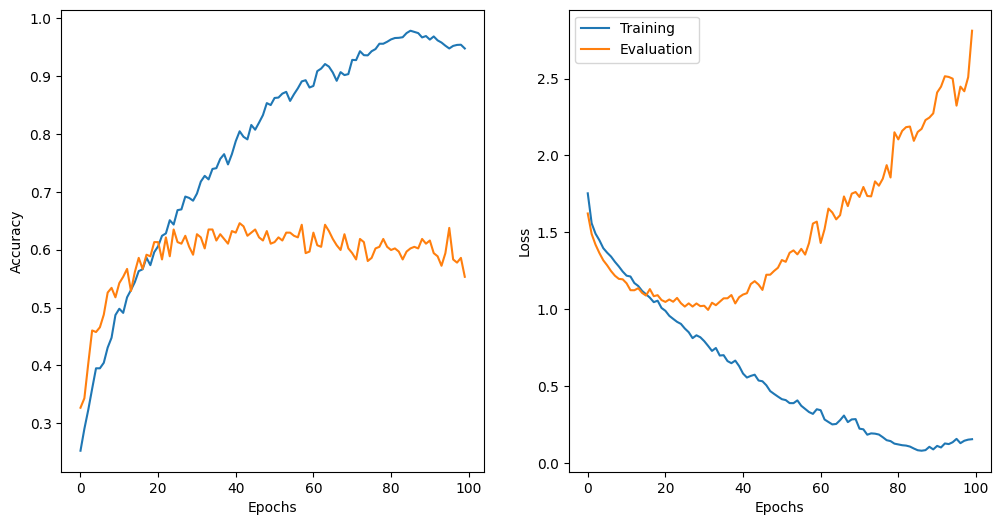

In [21]:
plot_result(
    num_epochs,
    metrics['train_accuracy'],
    metrics['train_loss'],
    metrics['valid_accuracy'],
    metrics['valid_loss']
)

#Fine-tuning

##Modeling

In [22]:
from transformers import ViTForImageClassification

id2label = {i:c for i, c in enumerate(classes)}
label2id = {c:i for i, c in enumerate(classes)}

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels = num_classes,
    id2label = id2label,
    label2id = label2id
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

##Metrics

In [24]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.2 MB/s eta 0:00:00


In [25]:
import evaluate
import numpy as np

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   return metric.compute(predictions=predictions, references=labels)

##Trainer

In [26]:
from transformers import ViTImageProcessor
from transformers import TrainingArguments, Trainer

feature_extractor = ViTImageProcessor.from_pretrained(
    'google/vit-base-patch16-224-in21k'
)

metric_name = "accuracy"

args = TrainingArguments(
    f"vit-flowers",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end = True,
    metric_for_best_model = metric_name,
    logging_dir='./logs',
    remove_unused_columns=False,
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [28]:
def collate_fn(batch):
    pixel_values = torch.stack([example[0] for example in batch])
    labels = torch.tensor([example[1] for example in batch])
    return {'pixel_values': pixel_values, 'labels': labels}

In [29]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor
)

<ipython-input-29-79516e7780fe>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


##Training

In [30]:
trainer.train()
outputs = trainer.predict(test_dataset)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: xinquyhung91005 (xinquyhung91005-tr-ng-i-h-c-khoa-h-c-t-nhi-n-hqg-hcm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.568501,0.953678
2,No log,0.269064,0.967302
3,No log,0.199266,0.978202
4,No log,0.173116,0.964578
5,No log,0.162437,0.964578
6,0.332900,0.156689,0.967302
7,0.332900,0.155124,0.961853
8,0.332900,0.153191,0.961853
9,0.332900,0.153118,0.964578
10,0.332900,0.153078,0.964578


TypeError: 'dict' object is not callable

In [31]:
outputs.metrics

{'test_loss': 0.24267429113388062,
 'test_accuracy': 0.9591280653950953,
 'test_runtime': 5.7156,
 'test_samples_per_second': 64.211,
 'test_steps_per_second': 2.1}